# DuckDB Python API
- the same way of loading sakila data as via terminal

In [40]:
import duckdb
from pathlib import Path

### read data frames one by one

In [41]:
# handle paths
duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

# connect to duckdb file with context manager
with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_scripts:
    conn.sql(ingest_scripts.read())
    # create pandas dataframe from the created duckdb connection
    description = conn.sql("DESC;").df()
    film = conn.sql("FROM film;").df()

In [42]:
# check out the created dataframes
film.head(2)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00


In [43]:
#type(description)
description.head(2)

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False


### read all the tables into dataframes

In [44]:
# create a dictionary to keep all the dataframes
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description['name']:
        dfs[name] = conn.sql(f"FROM {name};").df()

In [45]:
# check the resulting dictionary
dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

In [46]:
# each value for each key in the dictionary is a pd df
type(dfs["actor"])

pandas.core.frame.DataFrame

In [47]:
# check the content of the df
dfs["actor"].head(3)

,actor_id,first_name,last_name,last_update
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59
2,3.0,ED,CHASE,2021-03-06 15:51:59


# register dfs to duckdb

In [48]:
duckdb.register("actor", dfs["actor"])
duckdb.register("film", dfs["actor"])



In [49]:
table_names = ["film", "film_actor", "film_category", "actor", "category"]

for table_name in table_names:
    duckdb.register(table_name, dfs[table_name])

# show the results of the registration
duckdb.sql("DESC;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
2,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
3,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
4,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


### join the register tables

In [50]:
films_joined = duckdb.sql(""" 
                            SELECT 
                                CONCAT(a.first_name, ' ', a.last_name) AS actor,
                                a.actor_id::INT AS actor_id,
                                f.title,
                                f.description,
                                f.release_year,
                                f.rental_duration,
                                f.rating,
                                c.name AS category,
                            FROM film f
                            LEFT JOIN film_actor fa ON f.film_id = fa.film_id
                            LEFT JOIN actor a ON a.actor_id = fa.actor_id
                            LEFT JOIN film_category fc ON fc.film_id = f.film_id
                            LEFT JOIN category c ON fc.category_id = c.category_id
                        """).df()

films_joined.head(2)

,actor,actor_id,title,description,release_year,rental_duration,rating,category
0,PENELOPE GUINESS,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,PG,Documentary
1,PENELOPE GUINESS,1,ANACONDA CONFESSIONS,A Lacklusture Display of a Dentist And a Denti...,2006,3,R,Animation


# EDA with pandas
- a light introduction of pandas
- pandas library introduces a new data type which is dataframe
- dataframe is good with data processing
- advantagess:
  - python users can do data processing like sql coding
  - pandas use numpy at the backend --> good performance
  - etc
- Remember a df object is just an instantiation from df class, so that the df object can make sure of all the methods for the df class

In [51]:
# look at the column types of a df
films_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   actor            5465 non-null   object
 1   actor_id         5462 non-null   Int32 
 2   title            5465 non-null   object
 3   description      5465 non-null   object
 4   release_year     5465 non-null   object
 5   rental_duration  5465 non-null   int64 
 6   rating           5465 non-null   object
 7   category         5465 non-null   object
dtypes: Int32(1), int64(1), object(6)
memory usage: 325.7+ KB


In [52]:
# see unique values of a column
films_joined["category"].unique()

array(['Documentary', 'Animation', 'New', 'Games', 'Sci-Fi', 'Classics',
       'Horror', 'Sports', 'Family', 'Children', 'Foreign', 'Comedy',
       'Music', 'Action', 'Travel', 'Drama'], dtype=object)

In [53]:
# sorting rows
print(films_joined["rental_duration"].describe())

films_joined_sorted = films_joined.sort_values(by="rental_duration", ascending=False)

films_joined_sorted.head(3)

count    5465.000000
mean        4.986825
std         1.398667
min         3.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: rental_duration, dtype: float64


,actor,actor_id,title,description,release_year,rental_duration,rating,category
5447,THORA TEMPLE,200,CHRISTMAS MOONSHINE,A Action-Packed Epistle of a Feminist And a As...,2006,7,NC-17,Children
12,PENELOPE GUINESS,1,MULHOLLAND BEAST,A Awe-Inspiring Display of a Husband And a Squ...,2006,7,PG,Foreign
5438,JULIA FAWCETT,199,SHANGHAI TYCOON,A Fast-Paced Character Study of a Crocodile An...,2006,7,PG,Travel


In [54]:
# convert column from str to int
films_joined["release_year"].unique()

films_joined["release_year"] = films_joined["release_year"].astype(int)

films_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   actor            5465 non-null   object
 1   actor_id         5462 non-null   Int32 
 2   title            5465 non-null   object
 3   description      5465 non-null   object
 4   release_year     5465 non-null   int64 
 5   rental_duration  5465 non-null   int64 
 6   rating           5465 non-null   object
 7   category         5465 non-null   object
dtypes: Int32(1), int64(2), object(5)
memory usage: 325.7+ KB


In [55]:
# slicing of rows
films_joined_sorted.iloc[:3]

,actor,actor_id,title,description,release_year,rental_duration,rating,category
5447,THORA TEMPLE,200,CHRISTMAS MOONSHINE,A Action-Packed Epistle of a Feminist And a As...,2006,7,NC-17,Children
12,PENELOPE GUINESS,1,MULHOLLAND BEAST,A Awe-Inspiring Display of a Husband And a Squ...,2006,7,PG,Foreign
5438,JULIA FAWCETT,199,SHANGHAI TYCOON,A Fast-Paced Character Study of a Crocodile An...,2006,7,PG,Travel


# Visualization with pandas dataframe
  - graph the frequency counts for category

In [56]:
# create a df for frequency count
category_frequency_df = films_joined['category'].value_counts().reset_index()

category_frequency_df.head(3)

,category,count
0,Sports,442
1,Foreign,397
2,Documentary,385


<Axes: title={'center': 'Top 10 Film Category'}, xlabel='Category', ylabel='Number of films'>

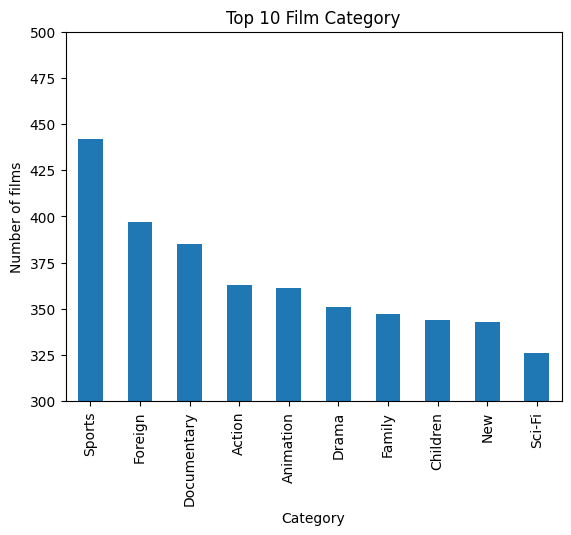

In [57]:
# plot the new df
# at the backend, the plot method of the df is using matplotlib (note that we did not import matplotlib)
category_frequency_df.head(10).plot(kind = "bar",   
                          x = "category",
                          y = "count",
                          xlabel = "Category",
                          ylabel = "Number of films",
                          title = "Top 10 Film Category",
                          legend=False,
                          ylim = [300,500])